# Exemple sur le modèle jouet Campbell

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import gpflow
import pyvista as pv

c:\Users\sliss\anaconda3\envs\PIR\lib\site-packages\gpflow\versions.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
%reload_ext autoreload
%autoreload 2
import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent))
import Methodes.model_class as model_class

On récupère les entrées.
On décide que c'est plus simple de couper en deux les 55 simulations qu'on a déjà.
On en prend:  
    - 50 pour l'entrainement  
    - 5 pour le test

In [4]:
hs_list = np.arange(1, 3.1, 0.5)
msl_list = np.arange(0, 1.1, 0.1)

x_train = np.array([[hs, msl] for hs in hs_list for msl in msl_list])

remove_points = np.array([
    [2., 0.2],
    [2.5, 0.5],
    [1.5, 0.6],
    [2., 0.8],
    [1., 1.]
])

to_remove = np.zeros(len(x_train), dtype=bool)
for rp in remove_points:
    to_remove |= np.all(np.isclose(x_train, rp, atol=1e-8), axis=1)

print("avant :", x_train.shape)       # (55, 2)
x_train = x_train[~to_remove]
print("après  :", x_train.shape)  # (50, 2)
print("x_train_filtered :",x_train)

avant : (55, 2)
après  : (50, 2)
x_train_filtered : [[1.  0. ]
 [1.  0.1]
 [1.  0.2]
 [1.  0.3]
 [1.  0.4]
 [1.  0.5]
 [1.  0.6]
 [1.  0.7]
 [1.  0.8]
 [1.  0.9]
 [1.5 0. ]
 [1.5 0.1]
 [1.5 0.2]
 [1.5 0.3]
 [1.5 0.4]
 [1.5 0.5]
 [1.5 0.7]
 [1.5 0.8]
 [1.5 0.9]
 [1.5 1. ]
 [2.  0. ]
 [2.  0.1]
 [2.  0.3]
 [2.  0.4]
 [2.  0.5]
 [2.  0.6]
 [2.  0.7]
 [2.  0.9]
 [2.  1. ]
 [2.5 0. ]
 [2.5 0.1]
 [2.5 0.2]
 [2.5 0.3]
 [2.5 0.4]
 [2.5 0.6]
 [2.5 0.7]
 [2.5 0.8]
 [2.5 0.9]
 [2.5 1. ]
 [3.  0. ]
 [3.  0.1]
 [3.  0.2]
 [3.  0.3]
 [3.  0.4]
 [3.  0.5]
 [3.  0.6]
 [3.  0.7]
 [3.  0.8]
 [3.  0.9]
 [3.  1. ]]


In [5]:
x_test = np.array([[2,0.2],[2.5,0.5],[1.5,0.6],[2,0.8],[1,1]])

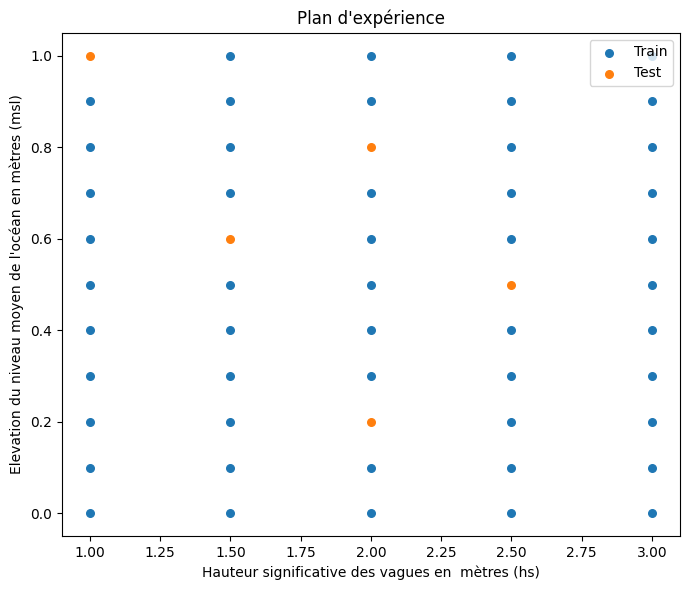

In [6]:
plt.figure(figsize=(7,6))
plt.scatter(x_train[:,0],x_train[:,1],label="Train",s=30)
plt.scatter(x_test[:,0],x_test[:,1],label="Test",s=30)
plt.xlabel("Hauteur significative des vagues en  mètres (hs)")  
plt.ylabel("Elevation du niveau moyen de l'océan en mètres (msl)")
plt.title("Plan d'expérience")
plt.legend()
plt.tight_layout()
plt.show()

## On récupère les sorties :
On utilise cette fonction pour récuperer les données présente dans un dossier

In [7]:
def Recuperer_data(base_folder,x):
    # On récupère le nombre de cellules terrestres
    cell_info = np.fromfile("data_malo_GP/scattered_land_data.bin",dtype=">f8").reshape(-1, 5)
    n_cells = cell_info.shape[0]
    id_gmsh = cell_info[:, 0].astype(int)-1  

    y_H_max = []
    y_H_moyenne = []

    for hs,msl in x:
            
            folder_name = f"run_msl_{msl:.1f}_hs_{hs:.1f}"
            file_path = os.path.join(base_folder, folder_name, "scattered_map_final.bin")

            if not os.path.exists(file_path):
                print("⚠️ Fichier manquant :", file_path)
                Hmax = np.full(n_cells, np.nan)
                Hmoyenne = np.full(n_cells, np.nan)
            else:
                # Lecture correcte du binaire (big-endian float64)
                data = np.fromfile(file_path, dtype=">f8").reshape(-1, 3)

                # Colonnes : [ID_global, Hmax_T, Hmean_T]
                Hmax = data[:, 1]   # Hauteur max
                Hmoyenne = data[:, 2]  # Hauteur moyenne

            y_H_max.append(Hmax)
            y_H_moyenne.append(Hmoyenne)
    
    y_H_max = np.array(y_H_max)
    y_H_moyenne = np.array(y_H_moyenne)

    return y_H_max,y_H_moyenne

On commence par les y_train qu'on récupère dans le dossier data_malo_GP/Train

In [8]:
y_train_H_max,y_train_H_moyenne = Recuperer_data("data_malo_GP/Train",x_train)
print("Taille de y_train_Hmax :", y_train_H_max.shape)
print("Taille de y_train_H_moyenne :", y_train_H_moyenne.shape)

Taille de y_train_Hmax : (50, 488290)
Taille de y_train_H_moyenne : (50, 488290)


Puis on récupère les y_test qu'on récupère dans le dossier data_malo_GP/Test

In [9]:
y_test_H_max,y_test_H_moyenne = Recuperer_data("data_malo_GP/Test",x_test)

print("Taille de y_test_H_max :", y_test_H_max.shape)
print("Taille de y_test_H_moyenne :", y_test_H_moyenne.shape)

Taille de y_test_H_max : (5, 488290)
Taille de y_test_H_moyenne : (5, 488290)


On choisit de regarder la hauteur d'eau max pour la suite

In [10]:
y_train = y_train_H_max #y_train_H_moyenne
y_test = y_test_H_max   #y_test_H_moyenne

In [11]:
n_pc = 5  # On choisit arbitrairement le nombre de composantes principales (d'après la thèse, 5 semble un bon compromis)
theta = 3 # On choisit arbitrairement la valeur de theta 
sigma = 1 # et de sigma
param = [theta, sigma]

kernel = gpflow.kernels.SquaredExponential(lengthscales=param[0], variance=param[1]**2) + gpflow.kernels.White(variance=1e-6)

In [12]:
# ACP ondelettes
ACP_wave = model_class.ACPF_Ondelettes(n_pc,[theta,sigma],p=0.9999,J=2)
ACP_wave.train(x_train,y_train,kernel_fn=kernel,verbose=True)

Nombre de coefficients conservés pour l'ACP : 218002

--- Entraînement du modèle GP pour la composante principale  1 ---
Modèle GP créé pour la composante principale  1 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  2 ---
Modèle GP créé pour la composante principale  2 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  3 ---
Modèle GP créé pour la composante principale  3 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  4 ---
Modèle GP créé pour la composante principale  4 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  5 ---
Modèle GP créé pour la composante principale  5 . Optimisation des hyperparamètres...
Optimisation terminée.
--- Analyse en Composantes Principales ---
Variance expliquée 

On regarde l'erreur si on prédit sur les données d'entrainement

In [13]:
Y_train_reconstruct_ACP_wave = ACP_wave.predict(x_train)  # On prédit sur les données d'entraînement pour vérifier la reconstruction

mse_ACP = np.mean((y_train - Y_train_reconstruct_ACP_wave)**2)
print("MSE ACP sur données d'entraînement :", mse_ACP)

Prédiction en cours...
MSE ACP sur données d'entraînement : 0.0029550392767517778


Et on regarde sur les données de test

In [14]:
Y_test_reconstruct_ACP_wave = ACP_wave.predict(x_test)  
 
mse_ACP = np.mean((y_test - Y_test_reconstruct_ACP_wave)**2)
print("MSE ACP sur données de test :", mse_ACP)

Prédiction en cours...
MSE ACP sur données de test : 0.007127873578389715


In [15]:
def plot_map(H_true, H_pred):
    mesh = pv.read("data_malo_GP/gmsh_mapping.vtk")
    cell_info = np.fromfile("data_malo_GP/scattered_land_data.bin",dtype=">f8").reshape(-1, 5)
    id_gmsh = cell_info[:, 0].astype(int) - 1  

    vtk_2_gmsh = mesh.cell_data["gmsh_cell_id"].astype(int) - 1
    gmsh_2_vtk = np.empty_like(vtk_2_gmsh)
    gmsh_2_vtk[vtk_2_gmsh] = np.arange(len(vtk_2_gmsh))
    id_vtk = gmsh_2_vtk[id_gmsh]

    submesh = mesh.extract_cells(id_vtk)

    mesh_true = submesh.copy()
    mesh_true.cell_data["H"] = H_true

    mesh_pred = submesh.copy()
    mesh_pred.cell_data["H"] = H_pred

    mesh_erreur = submesh.copy()
    mesh_erreur.cell_data["H"] = np.abs(H_pred-H_true)/(H_true+1e-6)

    # Plot
    plotter = pv.Plotter(shape=(1, 3))

    #Limite haute 
    #maximum = max(np.max(H_true), np.max(H_pred))


    # Subplot 0 : vrai
    plotter.subplot(0, 0)
    plotter.add_mesh(mesh_true, scalars="H", clim=[0,2], cmap="coolwarm")
    plotter.view_xy()
    plotter.add_title("Sortie réelle", font_size=12)

    # Subplot 1 : prédit
    plotter.subplot(0, 1)
    plotter.add_mesh(mesh_pred, scalars="H", clim=[0,2], cmap="coolwarm",show_scalar_bar=False)
    plotter.view_xy()
    plotter.add_title("Reconstruction", font_size=12)

    # Subplot 2 : erreur
    plotter.subplot(0, 2)
    plotter.add_mesh(mesh_erreur, scalars="H", clim=[0, 1], cmap="Oranges",show_scalar_bar=False)
    plotter.view_xy()
    plotter.add_title("Erreur", font_size=12)
    plotter.add_scalar_bar(title='Erreur |H|',interactive=False)


    plotter.show()

/home/davodeau/.conda/envs/HDDLtensorflow/lib/python3.12/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


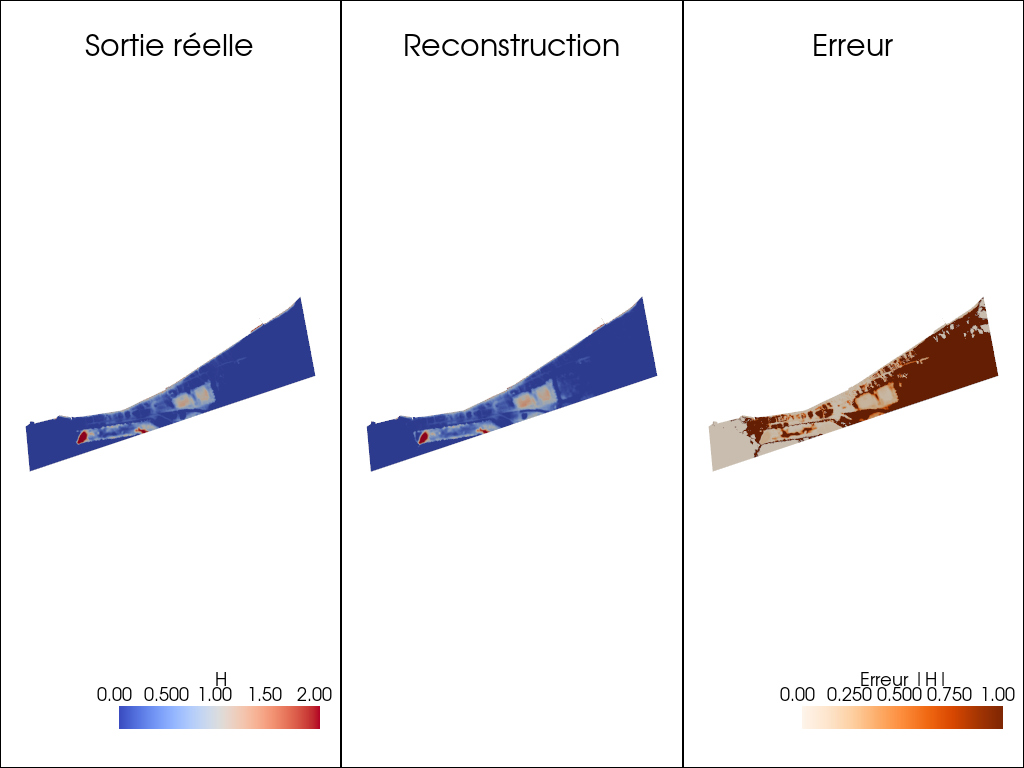

/home/davodeau/.conda/envs/HDDLtensorflow/lib/python3.12/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


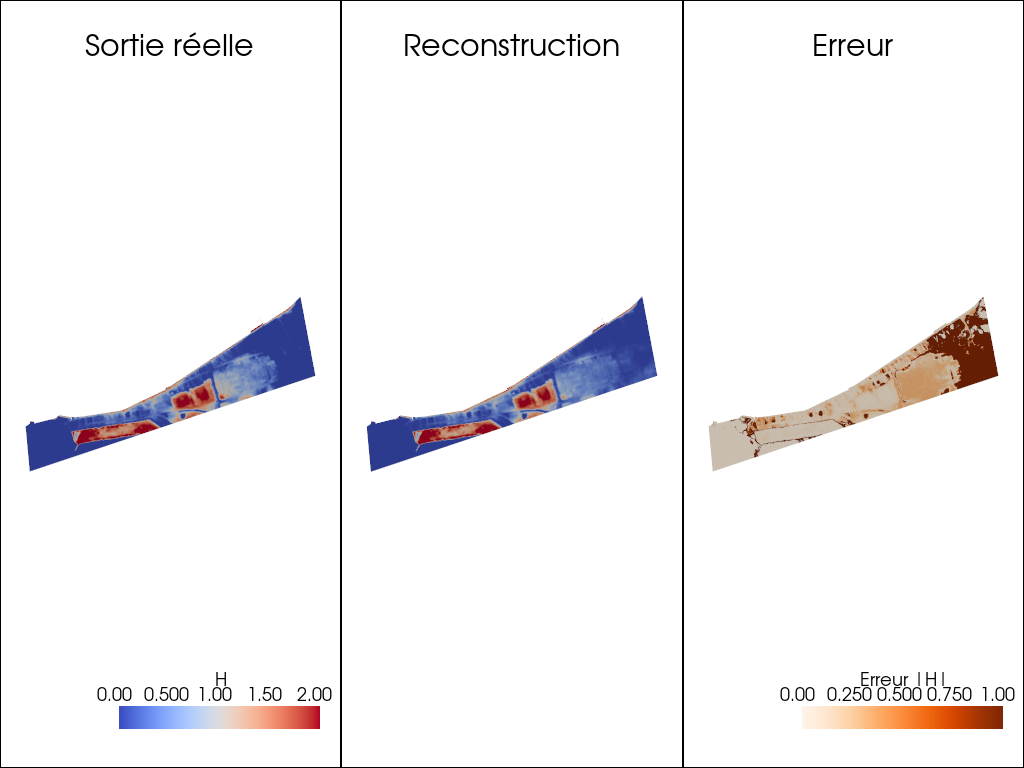

/home/davodeau/.conda/envs/HDDLtensorflow/lib/python3.12/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


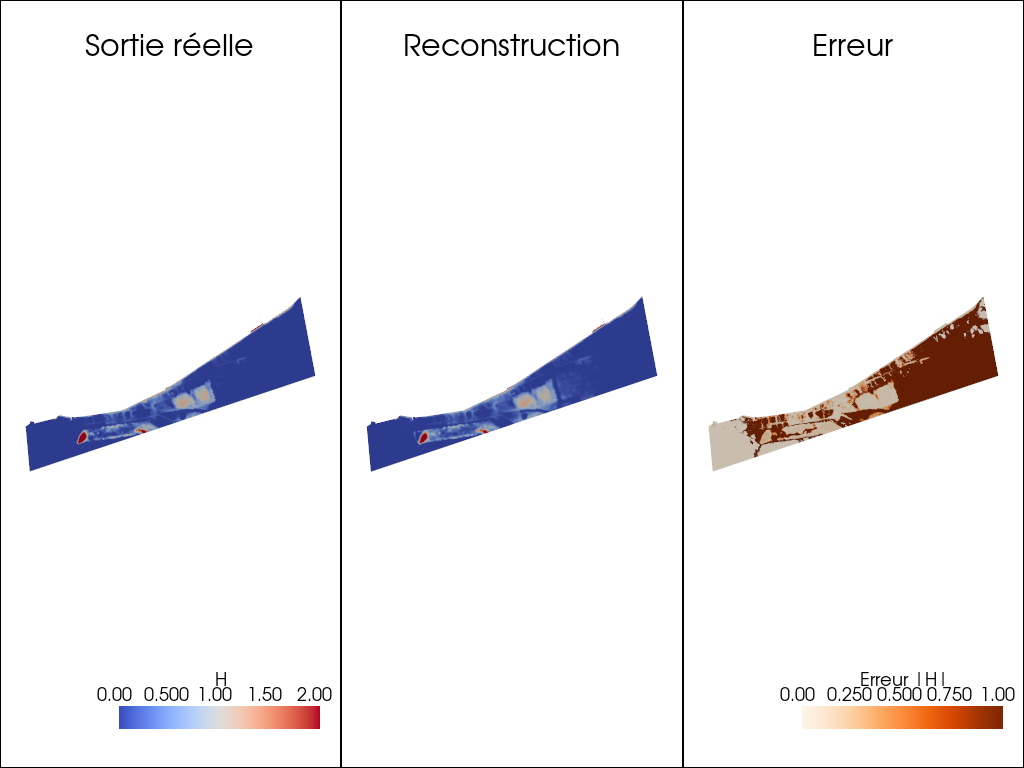

/home/davodeau/.conda/envs/HDDLtensorflow/lib/python3.12/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


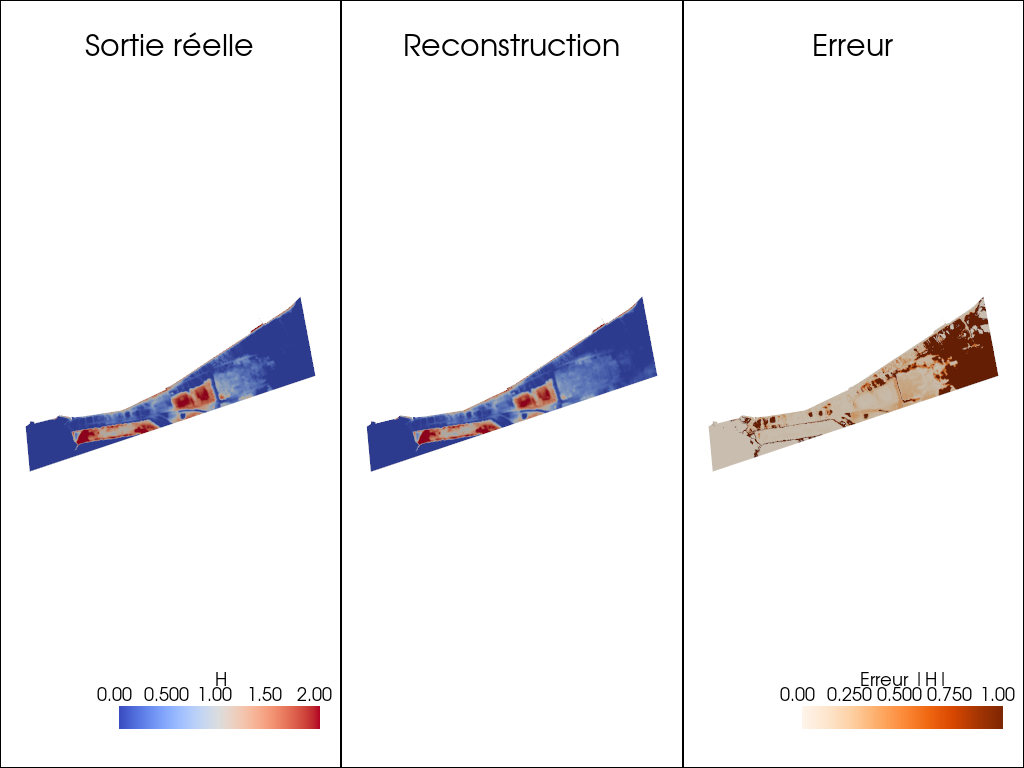

/home/davodeau/.conda/envs/HDDLtensorflow/lib/python3.12/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


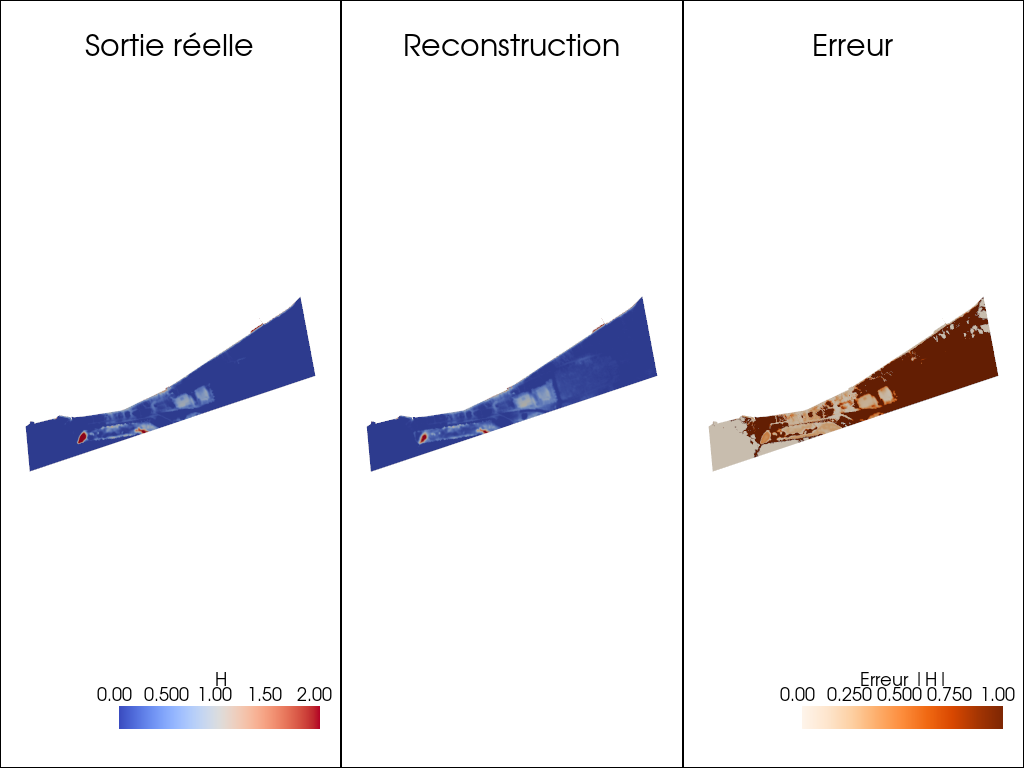

In [17]:
for i in range(5):
    plot_map(y_test[i,:],Y_test_reconstruct_ACP_wave[i,:])

On va maintenant regarder si en prédisant par les voisins proches on fait mieux (test si le modèle est très régulier)

In [23]:
# On récuprère les indices des voisins proches pour le point de test [2,0.2] 
x_neighbors = np.array([
    [1.5, 0.2],
    [2.0, 0.1],
    [2.0, 0.3],
    [2.5, 0.2]])
indices_neighbors = []
for xn in x_neighbors:  
    index = np.where((np.isclose(x_train, xn, atol=1e-8)).all(axis=1))[0][0]
    indices_neighbors.append(index)

#On récuperère les sorties correspondantes
y_neighbors = y_train[indices_neighbors,:]
#On fait la moyenne des sorties des voisins proches
y_pred_neighbors = np.mean(y_neighbors, axis=0)


c:\Users\sliss\anaconda3\envs\PIR\lib\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


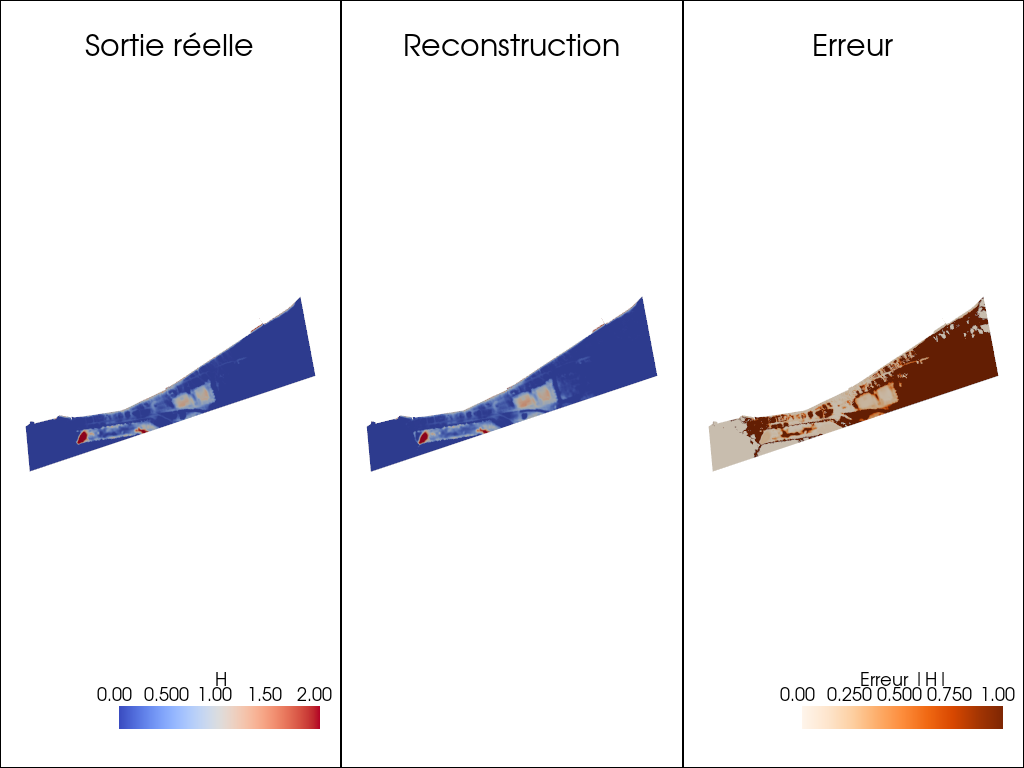

c:\Users\sliss\anaconda3\envs\PIR\lib\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


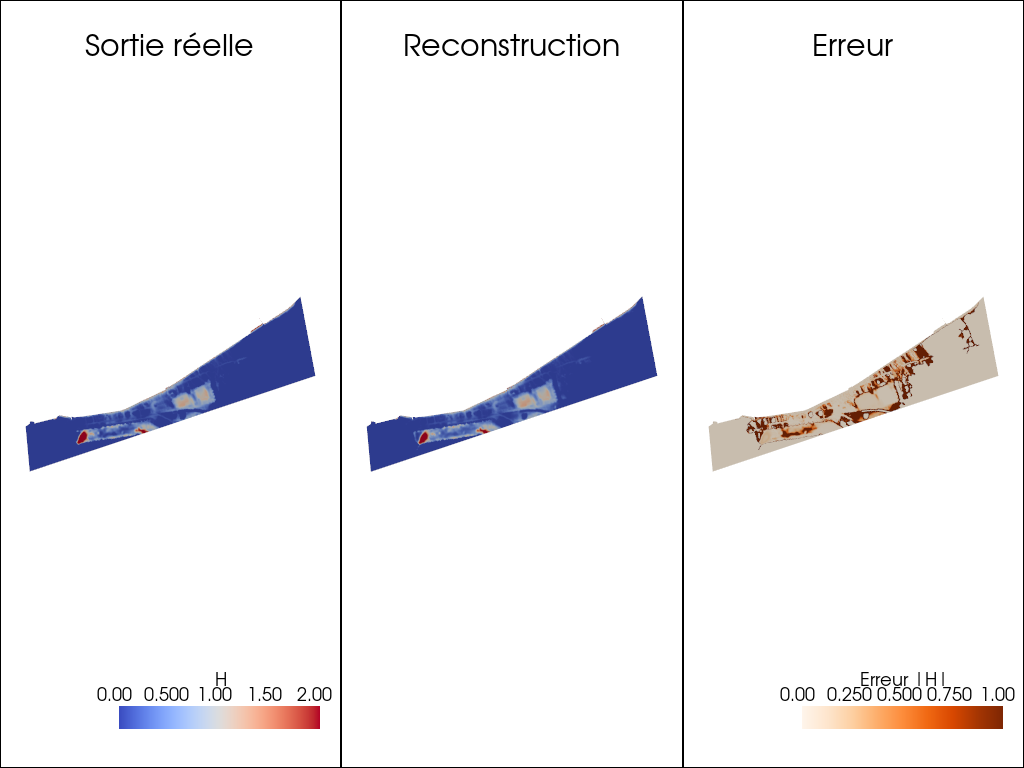

In [ ]:
#On va maintenant afficher la vraie carte, la carte prédite par ACP et celle prédite par les voisins proches pour le point de test [2,0.2]
index_test_point = 0  # Correspond au point de test [2,0.2]
#Prédiction par ACP 
plot_map(y_test[index_test_point,:],Y_test_reconstruct_ACP_wave[index_test_point,:])
#Prédiction par voisins proches
plot_map(y_test[index_test_point,:],y_pred_neighbors)

On observe de meilleures performances en utilisant les voisins proches pour la prédiction. Cela suggère que le modèle présente une certaine régularité locale, ce qui permet aux prédictions basées sur les voisins proches d'être plus précises que celles basées sur l'ACP seule. Cependant, il est important de noter que les données d'entrainement suivent ici un maillage régulier ce qui permet une interpolation plus efficace. Rien que s'il on prenait une simulation en dehors du maillage régulier comme donnée de test, la méthode des voisins proches pourrait ne pas être aussi performante. De plus, si les données d'entraînement avait été choisies de manière plus optimale (par exemple en utilisant un plan d'expérience de type LHS), la méthode des voisins proches perd beaucoup de son sens et aurait probablement des performances moindres comparées à l'ACP.

De plus, dans le cas temporel, la méthode des voisins proches peut être moins efficace en raison de la nature dynamique des données. Les conditions peuvent changer rapidement, et les points de données voisins dans le temps peuvent ne pas refléter fidèlement l'état actuel du système. Par conséquent, bien que la méthode des voisins proches puisse offrir des avantages dans certains contextes, son efficacité dépend fortement de la structure des données et du domaine d'application spécifique.